In [1]:
#imports 
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cesm import cesm_analyze as ca
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#Organizion of the different datasets into a dictionary
vardict = {
    'huss': {'name': 'Specific Humidity', 'units': ''},
    'hurs': {'name': 'Relative Humidity', 'units': '[%]'},
    'pr': {'name': 'Precipitation', 'units': '$[\frac{kg}{m^{2}s}]$'},
    'tas': {'name': 'Air Temperature', 'units': 'K'},
    'tasmin': {'name': 'Daily Min. Air Temperature', 'units': 'K'},
    'tasmax': {'name': 'Daily Max. Air Temperature', 'units': 'K'},
}
modeldict = {
    'hist': {
        'code': 'historical', 'name': 'Historical Data'
    },
    'sp1': {
        'code': 'ssp126', 'name': r'$Scenario \#1: 2.6 \frac{W}{m^{2}}$'
    },
    'sp2': {
        'code': 'ssp245', 'name': r'$Scenario \#2: 4.5 \frac{W}{m^{2}}$'
    },
    'sp3': {
        'code': 'ssp370', 'name': r'$Scenario \#3: 7.0 \frac{W}{m^{2}}$'
    },
    'sp5': {
        'code': 'ssp585', 'name': r'$Scenario \#5: 8.5 \frac{W}{m^{2}}$'
    },
}

#Opening each of the Xarray datasets
ds = ca.dictorize(
    func = xr.open_zarr, 
    modeldict = {k: v['code'] for k, v in modeldict.items()},
)

print(f'Available datasets: {list(ds)}')

#Creating var names for each dataset
hist = ds['hist']
sp1 = ds['sp1']
sp2 = ds['sp2']
sp3 = ds['sp3']
sp5 = ds['sp5']

Available datasets: ['hist', 'sp1', 'sp2', 'sp3', 'sp5']


In [21]:
baseline = (
    ds['hist']
    .sel(time=slice('1850', '1980'))
    .mean('time')
)


ds_diffs = ds.copy()
ds_diffs['hist'] = baseline
ds_diffs = ca.dictorize(
    func = 'diff',
    modeldict = ca.nest_dicts(
        ds_diffs,
    ),
)

USA = ca.dictorize(
    func = 'sel',
    modeldict = ca.nest_dicts(
        ds_diffs,
        {'args': {'time': '2100',
                 'lat': slice(0, 70),
                 'lon': slice(225,300)}},
    ),
)

USA = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        USA,
        {'grps': 'time.year', 'aggfunc': np.nanmean, 'roll': {}},
    ),
)

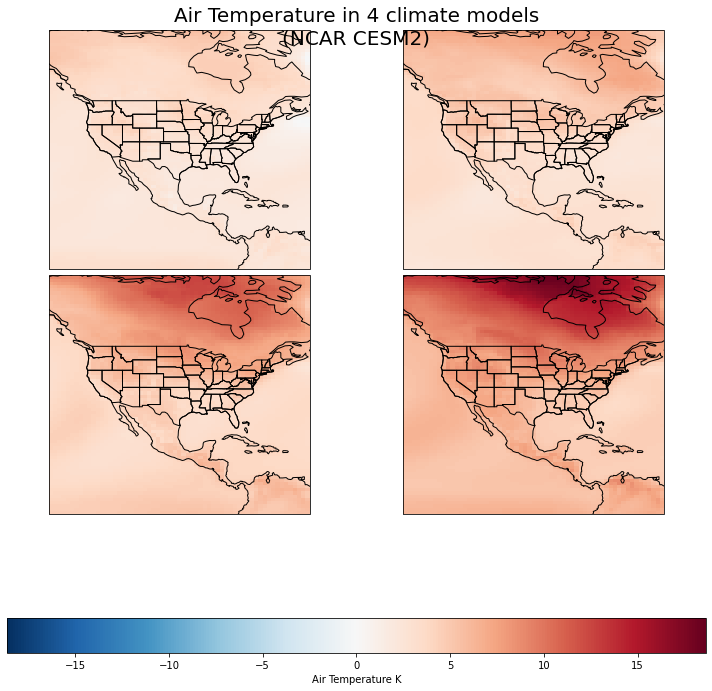

In [28]:
def plot_diff(d, var, crs, vardict, modeldict):
    """
    .
    """
    for k in d.keys():
        d[k][k] = d[k][var].copy()
    
    # ds = xr.combine_by_coords([d[k][k] for k in d.keys()])
    
    models = np.array(list(d))
    model_data = np.vstack(tuple([d[k][var].values for k in models]))

    ds = xr.Dataset(
        data_vars = {
            k: (['model', 'lat', 'lon'], model_data)
        },
        coords = {
            'model': models,
            'lat': d[models[0]]['lat'],
            'lon': d[models[0]]['lon'],
        }
    )

    ds = ds.rename({models[-1]: var})
    
    dplot = ds[var].plot(
        col='model', 
        col_wrap=2,
        transform=crs,
        figsize=(10, 10),
        # cmap='RdYlBu_r', vmin=-30, vmax=30, extend='neither',
        cbar_kwargs={
            "orientation": "horizontal",
            #'anchor': (0, 2),
            # "shrink": 0.8,
            "aspect": 20,
            'label': vardict[var]['name']+' '+vardict[var]['units'],
            # 'ticks': [-35, 0, 35],
            'spacing': 'proportional',
        },
        subplot_kws={
            'projection': crs,
        },
    )
    
    for i, ax in enumerate(dplot.axes.flatten()):
        sc = modeldict[models[i]]['name'].split(':')[0] + r'$'
        rcp = r'$' + modeldict[models[i]]['name'].split(':')[1]
        
        ax.add_feature(cfeature.STATES.with_scale("110m"))
        
        ax.coastlines("110m", color="k")
        #ax.set_xlim(-180, 180)
        ax.set_title('')
        ax.annotate(
            f'{sc}\n{rcp}',
            (-170, -40), # in lat, lon
            ha='left', va='center',
            color='black',
            fontsize=10,
        ).set(
            bbox={
                'facecolor': 'white', 
                'edgecolor': 'black'
            }
        )
    plt.suptitle(
        f"{vardict[var]['name']} in {len(models)} climate models\n(NCAR CESM2)",
        fontsize=20,
        ha='center', va='center',
        #x=0.5, y=0.9,
    )
    
plot_diff(USA, 'tas', crs, vardict, modeldict)

Here we have the difference between the historical average Near-Surface Air Temperature (K) and four different model predictions for the year 2100 in the North America region. The lighter regions represent less change in surface air temperature, and vice versa for the darker. We can see that the more northern areas seem to have greater predicted change. This could be due to those regions initally having more snow and ice, which when melted will result in substantially less reflection of incoming sunlight/heat. This process results in this visably larger difference in temperature than the other regions. 

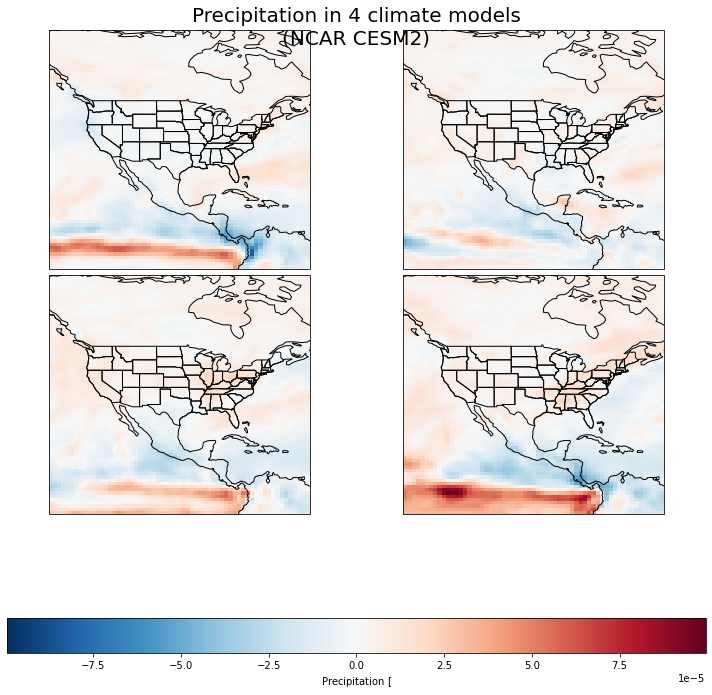

In [33]:
plot_diff(USA, 'pr', crs, vardict, modeldict)

Here we have the four model predictions for Precipitation $[\frac{kg}{m^{2}s}]$ levels in the North American region. There are a couple of interesting patterns to address here. In the first, or 'best case', model we can see that many of the South Western regions of the United States can expect a decrease in precipitation. However, in the other three models we can increasingly see a prediction of increased precipitation. This could be due many things, of which may include a phenomenon known as [evapotranspiration] (https://www.merriam-webster.com/dictionary/evapotranspiration) where the increase in heat will lead to more water being evaporated out of trees, crops, and the ground. These patterns may also be due to stronger [El nino events](https://www.climate.gov/enso). For all the models, Canada appears to have a steady and slight increase in precipitation while the more Southern part of North America such as Mexico can expect a gradual decrease in precipitation.

There is a very noticable red band on the equator that grows drastically darker with the severity of model. The Intertropical Convergence Zone is the region that circles the Earth, near the equator, where the trade winds of the Northern and Southern Hemispheres come together. The intense sun and warm water of the equator heats the air in the ITCZ, raising its humidity and making it buoyant. [Source](https://earthobservatory.nasa.gov/images/703/the-intertropical-convergence-zone#:~:text=The%20Intertropical%20Convergence%20Zone%2C%20or,humidity%20and%20making%20it%20buoyant.) We can see that as the model severity increases, the ITCZ is drastically increasing in amount of precipitaion. This can have serious consequences for extremem weather events. 

These predicitions were interesting to me because usually we associate climate change with heat and drought. However, water is not necessarily being lost, its just that the locations it is concentrated in or not become more extreme. 

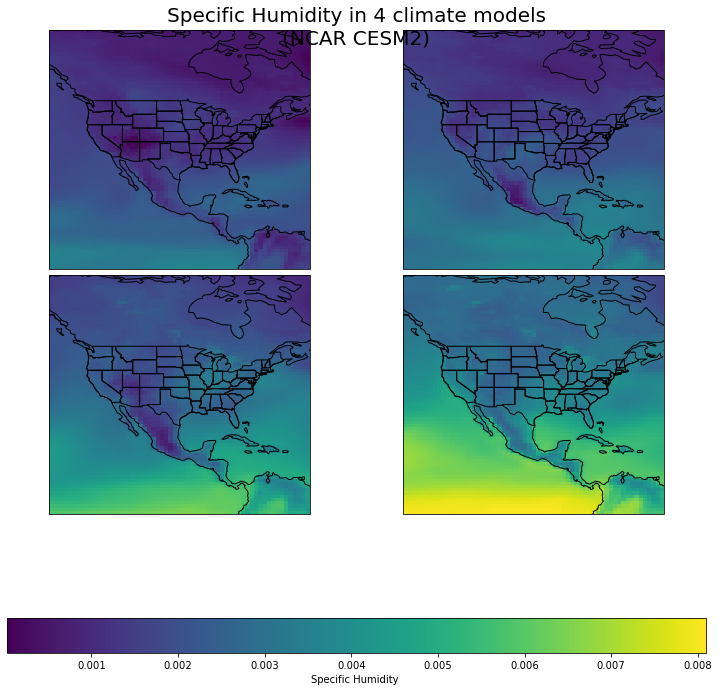

In [36]:
plot_diff(USA, 'huss', crs, vardict, modeldict)

Specific Humidity- The mass of water vapor per unit mass of air

https://www.merriam-webster.com/dictionary/evapotranspiration

In [ ]:
cv.plot_lines(
    data = ds_my['hist'][var], 
    path = path_htt, 
    xlab = '', 
    ylab = var_lab, 
    title = 'Global Annual Averages of Historical Air Surface Temperature'
)

In [18]:
#Select North American Region
USA = ca.dictorize(
    "sel", 
    ca.nest_dicts(
        ds,
        {'args': {'lat': slice(0, 70),
                 'lon': slice(225,300)}},
    )
)

###########################################################
# # Create new DataArrays as model names (for combining)
# for k in USA.keys():
#     USA[k][k] = USA[k]['tas'].copy()

# ###########################################################
model_data = np.vstack(tuple([USA[k]['tas'].values for k in USA.keys()]))
model_data.shape

(6108, 74, 61)

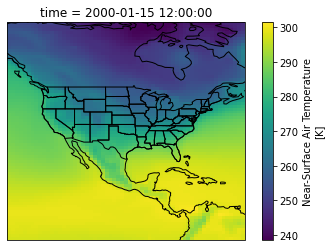

In [13]:
#Select North American Region
USA = ca.dictorize(
    "sel", 
    ca.nest_dicts(
        ds,
        {'args': {'lat': slice(0, 70),
                 'lon': slice(225,300)}},
    )
)

###########################################################
# # Create new DataArrays as model names (for combining)
# for k in USA.keys():
#     USA[k][k] = USA[k]['tas'].copy()

# ###########################################################
model_data = np.vstack(tuple([USA[k]['tas'].values for k in USA.keys()]))

# dplot = xr.Dataset(
#     data_vars = {
#         k: (['model', 'lat', 'lon'], model_data)
#     },
#     coords = {
#         'model': np.array(list(USA)),
#         'lat': USA['sp1']['lat'],
#         'lon': USA['sp1']['lon'],
#     }
# )

#dplot = dplot.rename({'sp5': 'tas'})

###########################################################

#Select projections
crs = ccrs.PlateCarree()
ax = plt.subplot(projection=crs)
USA["hist"].sel(time = "2000-01-15")["tas"].plot(ax=ax, transform=crs)

# Plot on a map
ax.coastlines("110m", color="k")
ax.add_feature(cfeature.STATES.with_scale("110m"))

#dplot['tas'].plot(col='model', col_wrap=2)

ValueError: conflicting sizes for dimension 'model': length 5 on 'model' and length 6108 on {'model': 'sp5', 'lat': 'sp5', 'lon': 'sp5'}

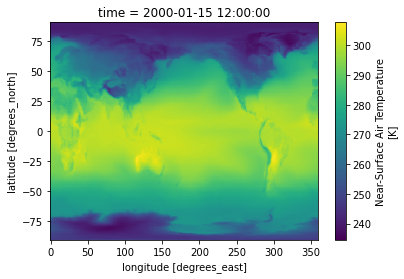

In [7]:
hist.sel(time = "2000-01-15")["tas"].plot()

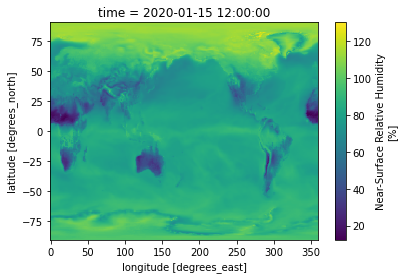

In [5]:
sp5.sel(time = "2020-01-15")["tas"].plot()

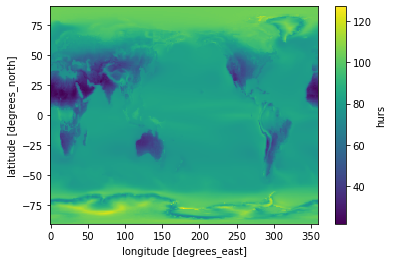

In [6]:
avg_hist = hist.mean("time").tas.plot()

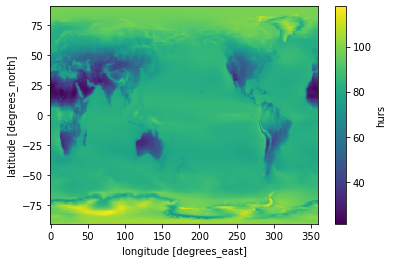

In [7]:
avg_sp5 = sp5.mean("time").hurs.plot()

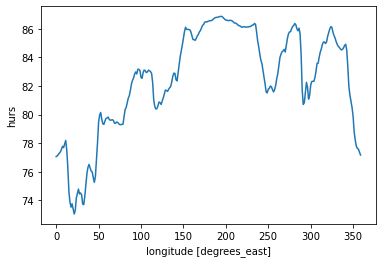

In [12]:
hist.mean(("lat", "time")).hurs.plot()

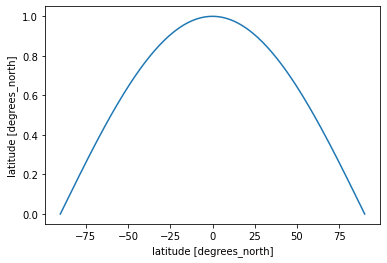

In [14]:
weights = np.cos(np.deg2rad(hist.lat))
weights.name = "weights"
weights.plot();

In [16]:
hist_weighted = hist.weighted(weights)
hist_weighted

DatasetWeighted with weights along dimensions: lat

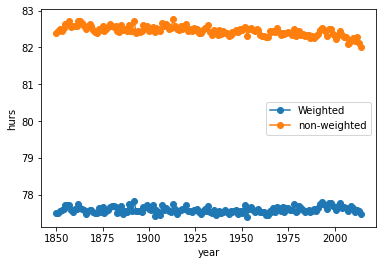

In [22]:
hist_weighted.mean(("lat", "lon")).groupby(hist.time.dt.year).mean().hurs.plot(marker='o', label="Weighted")
hist.groupby(hist.time.dt.year).mean().mean(("lat", "lon")).hurs.plot(marker='o', label="non-weighted")
plt.legend()

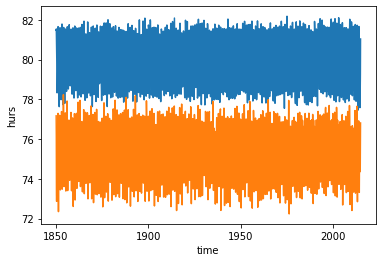

In [26]:
hist_south = hist.sel(lat=slice(-90,0))
hist_north = hist.sel(lat=slice(0,90))

weights_south = np.cos(np.deg2rad(hist_south.lat))
weights_north = np.cos(np.deg2rad(hist_north.lat))

hist_south_weigthed = hist_south.weighted(weights_south)
hist_north_weigthed = hist_north.weighted(weights_north)

t_hurs_south = hist_south_weigthed.mean(("lat", "lon")).hurs
t_hurs_south.plot();

t_hurs_north = hist_north_weigthed.mean(("lat", "lon")).hurs
t_hurs_north.plot();

In [28]:
def peak_tas(data):
    
    yy = data.time.dt.year
    min_y, max_y = yy.min().values.item(), yy.max().values.item()
    years = range(min_y, max_y + 1) 
    peaks = []
    
    for y in years:
        year = data.isel(time = data.time.dt.year == y)
        min_d, max_d = year.idxmin(), year.idxmax()
        min_v, max_v = year.sel(time = min_d), year.sel(time = max_d)
        min_day, max_day = min_d.dt.dayofyear, max_d.dt.dayofyear
        vals = [x.values.item() for x in [min_day, max_day, min_v, max_v, (max_v-min_v)]] 
        peaks.append([y, min_d.values, max_d.values] + vals)

    peaks = pd.DataFrame(peaks, 
                              columns = ['year', 'min_date', 'max_date',
                                         'min_dayofyear', 'max_dayofyear',
                                         'min_tas', 'max_tas', 'amplitude'])
    return peaks

peaks_north = peak_tas(t_hurs_north)